# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [110]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score


import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

from tqdm import tqdm

In [199]:
df_one_hot = pd.read_csv(r'C:\Users\david\Desktop\мага\Статистика и машинное обучение\LR5\LR5\penguins_binary_classification.csv')

df_target_enc = pd.read_csv(r'C:\Users\david\Desktop\мага\Статистика и машинное обучение\LR5\LR5\penguins_binary_classification.csv')

In [200]:
#df.groupby('species').agg(['mean', 'std', 'count'])
#df['species'] = df['species'].replace({'Adelie': 1, 'Gentoo': 0})
#df[df.isna().any(axis=1)]
#df.isna().sum()
#df.describe().style.format("{:.4}")

In [201]:
df_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            274 non-null    object 
 1   island             274 non-null    object 
 2   bill_length_mm     274 non-null    float64
 3   bill_depth_mm      274 non-null    float64
 4   flipper_length_mm  274 non-null    float64
 5   body_mass_g        274 non-null    float64
 6   year               274 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.1+ KB


In [202]:
df_one_hot.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


In [203]:
#import ace_tools as tools; 
#tools.display_dataframe_to_user(name="Основные статистики набора данных Penguins", dataframe=statistics)


In [204]:
df_one_hot[df_one_hot['species']=='Adelie'].describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,151.000000,151.000000,151.000000,151.000000,151.000000
mean,38.791391,18.346358,189.953642,3700.662252,2008.019868
std,2.663405,1.216650,6.539457,458.566126,0.820327
min,32.100000,15.500000,172.000000,2850.000000,2007.000000
25%,36.750000,17.500000,186.000000,3350.000000,2007.000000
50%,38.800000,18.400000,190.000000,3700.000000,2008.000000
75%,40.750000,19.000000,195.000000,4000.000000,2009.000000
max,46.000000,21.500000,210.000000,4775.000000,2009.000000


In [205]:
df_one_hot[df_one_hot['species']=='Gentoo'].describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,123.000000,123.000000,123.000000,123.000000,123.000000
mean,47.504878,14.982114,217.186992,5076.016260,2008.073171
std,3.081857,0.981220,6.484976,504.116237,0.791043
min,40.900000,13.100000,203.000000,3950.000000,2007.000000
25%,45.300000,14.200000,212.000000,4700.000000,2007.000000
50%,47.300000,15.000000,216.000000,5000.000000,2008.000000
75%,49.550000,15.700000,221.000000,5500.000000,2009.000000
max,59.600000,17.300000,231.000000,6300.000000,2009.000000


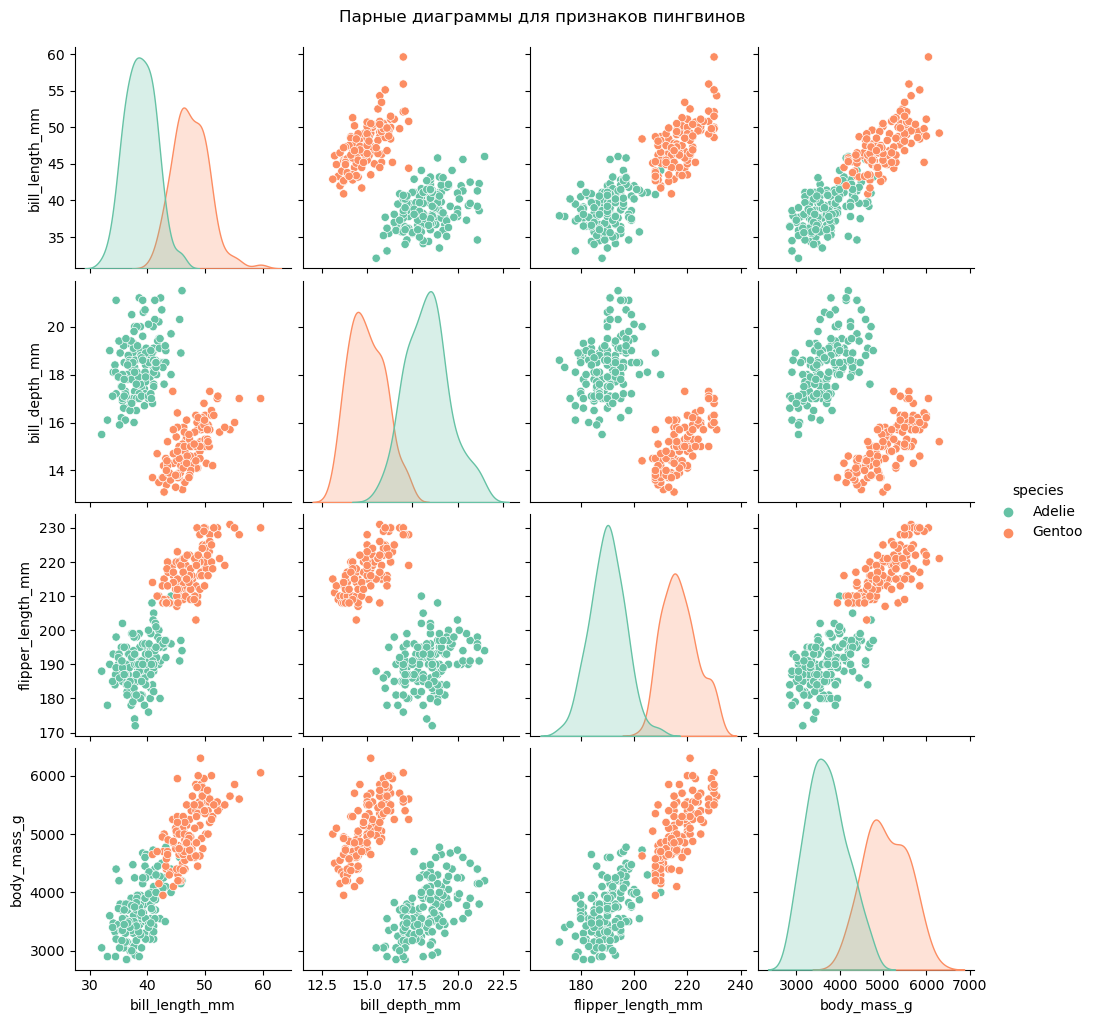

In [206]:
 # парная диаграмма 
sns.pairplot(df_one_hot.drop(columns=['year']), hue='species', diag_kind='kde', palette='Set2')
plt.suptitle('Парные диаграммы для признаков пингвинов', y=1.02)
plt.show()

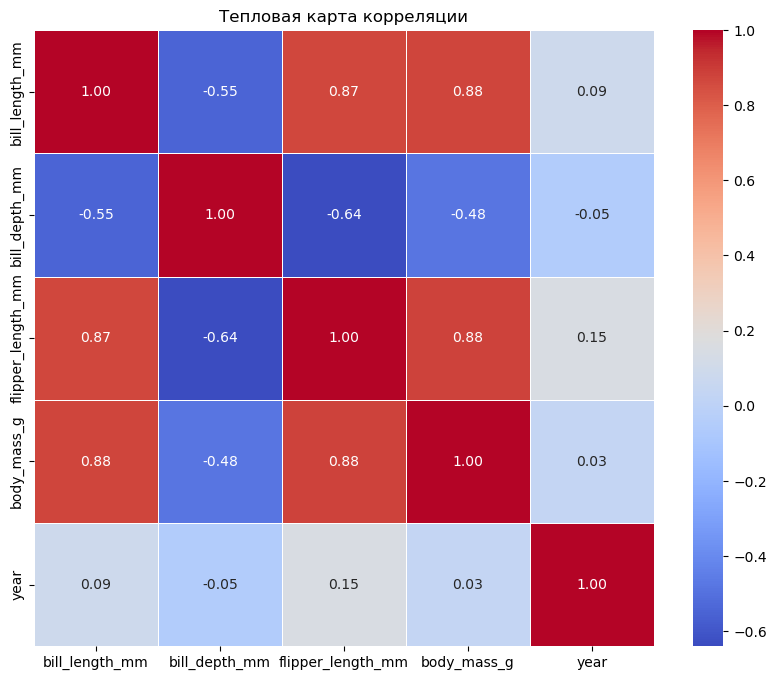

In [207]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_one_hot.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Тепловая карта корреляции')
plt.show()

In [208]:
#преобразую целевую переменную
df_one_hot.loc[df_one_hot['species'] == 'Adelie', 'species'] = 0
df_one_hot.loc[df_one_hot['species'] == 'Gentoo', 'species'] = 1

df_target_enc.loc[df_target_enc['species'] == 'Adelie', 'species'] = 0
df_target_enc.loc[df_target_enc['species'] == 'Gentoo', 'species'] = 1

In [209]:
df_one_hot['island'].value_counts()

Biscoe       167
Dream         56
Torgersen     51
Name: island, dtype: int64

In [210]:
df_one_hot = pd.get_dummies(df_one_hot, columns=['island'], drop_first=True)
df_target_enc['island'] = smoothed_target_encoding(df_target_enc, 'island', 'species', 50)

In [276]:
#Target Encoder преобразует категориальные переменные в числовые
#используя информацию о целевой переменной. Для каждой категории вычисляется среднее целелвой переменной для всех записей этой категории

def smoothed_target_encoding(df, cat_feature, target, smoothing_param):
    mean_target = df[target].mean()
    agg = df.groupby(cat_feature)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    smooth = (counts * means + smoothing_param * mean_target) / (counts + smoothing_param)
    return df[cat_feature].map(smooth)

class MyBinLog:
    def __init__(self, method='gd', learning_rate=0.01, max_iter=500, regularization=None, alpha=0.1, l1_ratio=0.5):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.coefs_ = None
        self.feature_names_in_ = None
        self.method = method
        self.regularization = regularization
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # Добавление параметра l1_ratio

    def sigmoid(self, z):
        """Сигмоидная функция"""
        return 1 / (1 + np.exp(-z))
    
    def _apply_regularization(self, gradient):
        """
        Применение регуляризации к градиенту.
        """
        if self.regularization == 'l2':
            regularization_term = self.coefs_.copy()
            regularization_term[0] = 0  # Не штрафуем смещение (bias)
            gradient -= self.alpha * regularization_term

        elif self.regularization == 'l1':
            regularization_term = np.sign(self.coefs_)
            regularization_term[0] = 0  # Не штрафуем смещение (bias)
            gradient -= self.alpha * regularization_term

        elif self.regularization == 'elasticnet':
            l1_term = self.l1_ratio * np.sign(self.coefs_)
            l2_term = (1 - self.l1_ratio) * self.coefs_
            l1_term[0] = 0  # Не штрафуем смещение (bias)
            l2_term[0] = 0
            gradient -= self.alpha * (l1_term + l2_term)

        return gradient

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):

        X = np.array(X, dtype=np.float64) 
        y = np.array(y).reshape(-1, 1).astype(np.float64)

        n_samples, n_features = X.shape
        self.coefs_ = np.zeros((n_features + 1, 1), dtype=np.float64)  # включая сдвиг

        # добаляю столбец единиц к X для учета сдвига
        X_with_bias = np.hstack((np.ones((n_samples, 1)), X))
        X_with_bias = X_with_bias.astype(np.float64) 
        
        if self.method == "gd":
            for _ in range(self.max_iter):

                z = np.dot(X_with_bias, self.coefs_)

                # применяю сигмоидную функцию для расчета вероятностей
                predictions = self.sigmoid(z)

                gradient = np.dot(X_with_bias.T, (y - predictions))
                #gradient = np.zeros((n_features+1, 1))

                #for i in range(len(predictions)):
                 #   gradient +=np.dot(X_with_bias[i, :].reshape(n_features+1, 1), (y[i] - predictions[i]).reshape(-1, 1))
                #применяю регуляризацию
                gradient = self._apply_regularization(gradient)
                
                self.coefs_ += self.learning_rate * gradient

                
        elif self.method == "sgd":
            
            for i in range(self.max_iter):
                rnd_idx = np.random.randint(0, n_samples)
                X_i = X_with_bias[rnd_idx, :].reshape(1, -1)
                y_i = y[rnd_idx].reshape(-1, 1) 
                z_i = np.dot(X_i, self.coefs_)
                prediction = self.sigmoid(z_i)
                gradient = (y_i - prediction) * X_i.T
                
                gradient = self._apply_regularization(gradient)
                self.coefs_ += self.learning_rate * gradient

            
        elif self.method == "newton":
            # Метод Ньютона
            for _ in range(self.max_iter):
                z = np.dot(X_with_bias, self.coefs_)

                predictions = self.sigmoid(z)

                # диагональная матрицу R (f(z) * (1 - f(z)))
                R = np.diag((predictions * (1 - predictions)).flatten())

                gradient = np.dot(X_with_bias.T, (y - predictions))
                
                gradient = self._apply_regularization(gradient)

                hessian = -np.dot(X_with_bias.T, np.dot(R, X_with_bias))
                
                if self.regularization == 'l2':
                    hessian -= self.alpha * np.eye(hessian.shape[0])

                #hessian += np.eye(hessian.shape[0]) * 1e-6  # Регуляризация

                self.coefs_ -= np.dot(np.linalg.pinv(hessian), gradient)

    def predict_proba(self, X: np.array):
        """
        Возвращает предсказанные вероятности класса 1

        X: Матрица признаков 
        """
        X = np.array(X, dtype=np.float64)
        n_samples = X.shape[0]

        # добаляю столбец единиц к X для учета сдвига
        X_with_bias = np.hstack((np.ones((n_samples, 1)), X))
        X_with_bias = X_with_bias.astype(np.float64) 
        z = np.dot(X_with_bias, self.coefs_)
        return self.sigmoid(z)

    def predict(self, X: np.array):
        probabilities = self.predict_proba(X)
        return (probabilities >= 0.5).astype(int)


In [83]:
#преобразую категориальную переменную island с использованием target encoder
#target_encoder = TargetEncoder(cols=['island'])
#df['island_encoder'] = target_encoder.fit_transform(df['island'], df['species'])

In [285]:
df_target_enc

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,0,0.222230,39.1,18.7,181.0,3750.0,2007
1,0,0.222230,39.5,17.4,186.0,3800.0,2007
2,0,0.222230,40.3,18.0,195.0,3250.0,2007
3,0,0.222230,36.7,19.3,193.0,3450.0,2007
4,0,0.222230,39.3,20.6,190.0,3650.0,2007
...,...,...,...,...,...,...,...
269,1,0.670255,47.2,13.7,214.0,4925.0,2009
270,1,0.670255,46.8,14.3,215.0,4850.0,2009
271,1,0.670255,50.4,15.7,222.0,5750.0,2009
272,1,0.670255,45.2,14.8,212.0,5200.0,2009


In [296]:
iterations_list = [1, 10, 100]
alpha_values = [0.001, 0.01, 0.1]
regularizations = [None, 'l1', 'l2', 'elasticnet']

results = []

#данные с  endcoding

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(df_target_enc.iloc[:, 1:], df_target_enc.iloc[:, 0], train_size=0.6, stratify=df.iloc[:, 0], random_state=55)

#данные с  one hot
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(df_one_hot.iloc[:, 1:], df_one_hot.iloc[:, 0], train_size=0.6,  stratify=df.iloc[:, 0], random_state=45)


In [293]:
reg_enc = MyBinLog(method=method, max_iter=iterr, learning_rate=alpha, regularization=regularization)

reg_enc.fit(X_train_enc, y_train_enc)


In [294]:
reg_enc_pred = reg_enc.predict(X_test_enc)


l1:Применяется к весам модели, добавляя штраф за сумму модулей весов.

Подходит для gd и sgd, но не рекомендуется для newton, так как L1 регуляризация не имеет гладкой второй производной, что может вызвать проблемы при вычислении гессиана

l2:Добавляет штраф за квадрат весов модели. Подходит для всех

In [297]:
regularizations = [None, 'l1', 'l2', 'elasticnet']

for iterr in iterations_list:
    for alpha in alpha_values:
        for method in ['gd', 'sgd', 'newton']:
            for regularization in regularizations:
                # для ньютона не используется заданная регуляризация
                if method == 'newton' and regularization in ['l1', 'elasticnet']:
                    continue

                # моедльдля encoding
                reg_enc = MyBinLog(method=method, max_iter=iterr, learning_rate=alpha, regularization=regularization)
                
                #  моедльдля one-hot
                reg_oh = MyBinLog(method=method, max_iter=iterr, learning_rate=alpha, regularization=regularization)
                
                # оачение на Target Encoding
                reg_enc.fit(X_train_enc, y_train_enc)
                reg_enc_pred = reg_enc.predict(X_test_enc)
                y_test_enc = y_test_enc.astype(int)
                reg_enc_pred = reg_enc_pred.flatten().astype(int)
                f1_score_enc = f1_score(y_test_enc, reg_enc_pred)
                
                # обучение наone-hot
                reg_oh.fit(X_train_oh, y_train_oh)
                reg_oh_pred = reg_oh.predict(X_test_oh)
                y_test_oh = y_test_oh.astype(int)
                reg_oh_pred = reg_oh_pred.flatten().astype(int)
                oh_f1_score = f1_score(y_test_oh, reg_oh_pred)
                
                results.append({
                    'Encoding': 'Target-Encoding',
                    'Method': method,
                    'Iterations': iterr,
                    'Alpha': alpha,
                    'Regularization': regularization,
                    'F1 Score': f1_score_enc
                })
                results.append({
                    'Encoding': 'One-Hot',
                    'Method': method,
                    'Iterations': iterr,
                    'Alpha': alpha,
                    'Regularization': regularization,
                    'F1 Score': oh_f1_score
                })

results_df = pd.DataFrame(results)


C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Use

C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Users\david\AppData\Local\Temp\ipykernel_15800\1150039097.py:26: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
C:\Use

In [ ]:
#статистика без резуляризации

In [299]:
results_df

,Encoding,Method,Iterations,Alpha,Regularization,F1 Score
0,Target-Encoding,gd,1,0.001,None,0.616352
1,One-Hot,gd,1,0.001,None,0.616352
2,Target-Encoding,gd,1,0.001,l1,0.616352
3,One-Hot,gd,1,0.001,l1,0.616352
4,Target-Encoding,gd,1,0.001,l2,0.616352
...,...,...,...,...,...,...
175,One-Hot,sgd,100,0.100,elasticnet,0.000000
176,Target-Encoding,newton,100,0.100,None,1.000000
177,One-Hot,newton,100,0.100,None,1.000000
178,Target-Encoding,newton,100,0.100,l2,0.989899


In [320]:
results_df[(results_df['Encoding'] == 'Target-Encoding') & 
           (pd.isna(results_df['Regularization']))].groupby('Method')['F1 Score'].mean()


Method
gd        0.507856
newton    1.000000
sgd       0.480702
Name: F1 Score, dtype: float64

In [321]:
results_df[(results_df['Encoding'] == 'One-Hot') & 
           (pd.isna(results_df['Regularization']))].groupby('Method')['F1 Score'].mean()


Method
gd        0.398687
newton    1.000000
sgd       0.347508
Name: F1 Score, dtype: float64

In [322]:
results_df[results_df['Encoding'] == 'Target-Encoding'].groupby('Method')['F1 Score'].mean()

Method
gd        0.466300
newton    0.996633
sgd       0.429711
Name: F1 Score, dtype: float64

In [323]:
results_df[results_df['Encoding'] == 'One-Hot'].groupby('Method')['F1 Score'].mean()

Method
gd        0.378694
newton    1.000000
sgd       0.308918
Name: F1 Score, dtype: float64

In [310]:
clf = LogisticRegression(max_iter=15).fit(X_train_enc, y_train_enc.astype(int))
y_pred = clf.predict(X_test_enc)
f1_score(y_test_enc.astype(int), y_pred.flatten().astype(int))

C:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9278350515463918

In [ ]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc

# Черновик

In [128]:
X, y = make_classification(
    n_samples=500,    
    n_features=4,        
    n_classes=2,          
    n_informative=4,     # кол информативных признаков
    n_redundant=0,       # кол избыточных признаков
    n_clusters_per_class=2,  #один кластер на класс
    class_sep=1,       # степень разделимости классов
    random_state=11 
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


In [13]:
def sigmoid(z):
    """сигмоидная функция"""
    return 1 / (1 + np.exp(-z))

In [380]:
num, features = X_train.shape
coefs_ = np.zeros((features, 1))
#coefs_ = np.random.randint(1, 5, size = coefs_.shape)
learning_rate = 0.01

In [387]:
for i in range(4):
    idx = np.random.randint(0, num)
    X_i = X_train[idx].reshape(1, -1)  
    y_i = y_train[idx].reshape(-1, 1) 
    
    z = X_i @ coefs_
    prob = sigmoid(z)
    gradient = X_i.T @ (y_i - prob)
    coefs_ += learning_rate * gradient

In [388]:
prob_pred = sigmoid(X_test @ coefs_)

In [389]:
f1_score(y_test, (prob_pred > 0.5).astype(int))

0.7777777777777778

In [22]:
num, features = X_train.shape
coefs_ = np.zeros((features, 1))
#coefs_ = np.random.randint(1, 4, (coefs_.shape))

In [23]:
for _ in range(100):
    z = X_train @ coefs_
    prob = sigmoid(z)

    #расчет диагональный матрицыR (f(z) * (1 - f(z)))
    R = np.diag((prob * (1 - prob)).flatten()) 
    grad = X_train.T @ (y_train.reshape(-1 , 1) - prob)
    # гессиан
    hessian = -(X_train.T @ (R @ X_train))

    coefs_ -= (np.linalg.pinv(hessian) @ grad)

In [24]:
prob_pred = sigmoid(X_test @ coefs_)

In [25]:
f1_score(y_test, (prob_pred > 0.5).astype(int))

0.782608695652174

In [120]:
grad = X_train.T @ (y_train.reshape(-1 , 1) - prob)
hessian = -(X_train.T @ R @ X_train)

coefs_ += (np.linalg.pinv(hessian) @ gradient)

array([[ 0.08486376, -0.99077294,  1.40317589,  1.51034653],
       [-1.52695121, -0.39535403, -0.64216786,  2.27262802],
       [ 0.92047925, -2.28159674,  0.42359604,  1.31726639],
       ...,
       [-0.65781562, -1.4962295 ,  1.19295609, -0.29323812],
       [ 0.61706311, -1.03604246,  2.7616694 , -0.51627118],
       [-0.65412762,  1.67550363,  3.23311854,  1.04621076]])

In [ ]:
for _ in range(self.max_iter):
    z = np.dot(X_with_bias, self.coefs_)

    predictions = self.sigmoid(z)

    #расчет диагональный матрицыR (f(z) * (1 - f(z)))
    R = np.diag((predictions * (1 - predictions)).flatten()) 
    gradient = np.dot(X_with_bias.T, (y - predictions))
    gradient = self._apply_regularization(gradient)
    # гессиан
    hessian = -np.dot(X_with_bias.T, np.dot(R, X_with_bias))

    self.coefs_ -= np.dot(np.linalg.pinv(hessian), gradient)

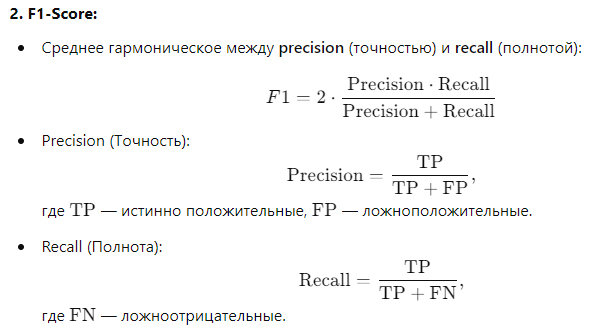

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

In [324]:
X, y = make_classification(
    n_samples=500,    
    n_features=4,        
    n_classes=3,          
    n_informative=4,     # кол информативных признаков
    n_redundant=0,       # кол избыточных признаков
    n_clusters_per_class=2,  #один кластер на класс
    class_sep=1,       # степень разделимости классов
    random_state=22 
)

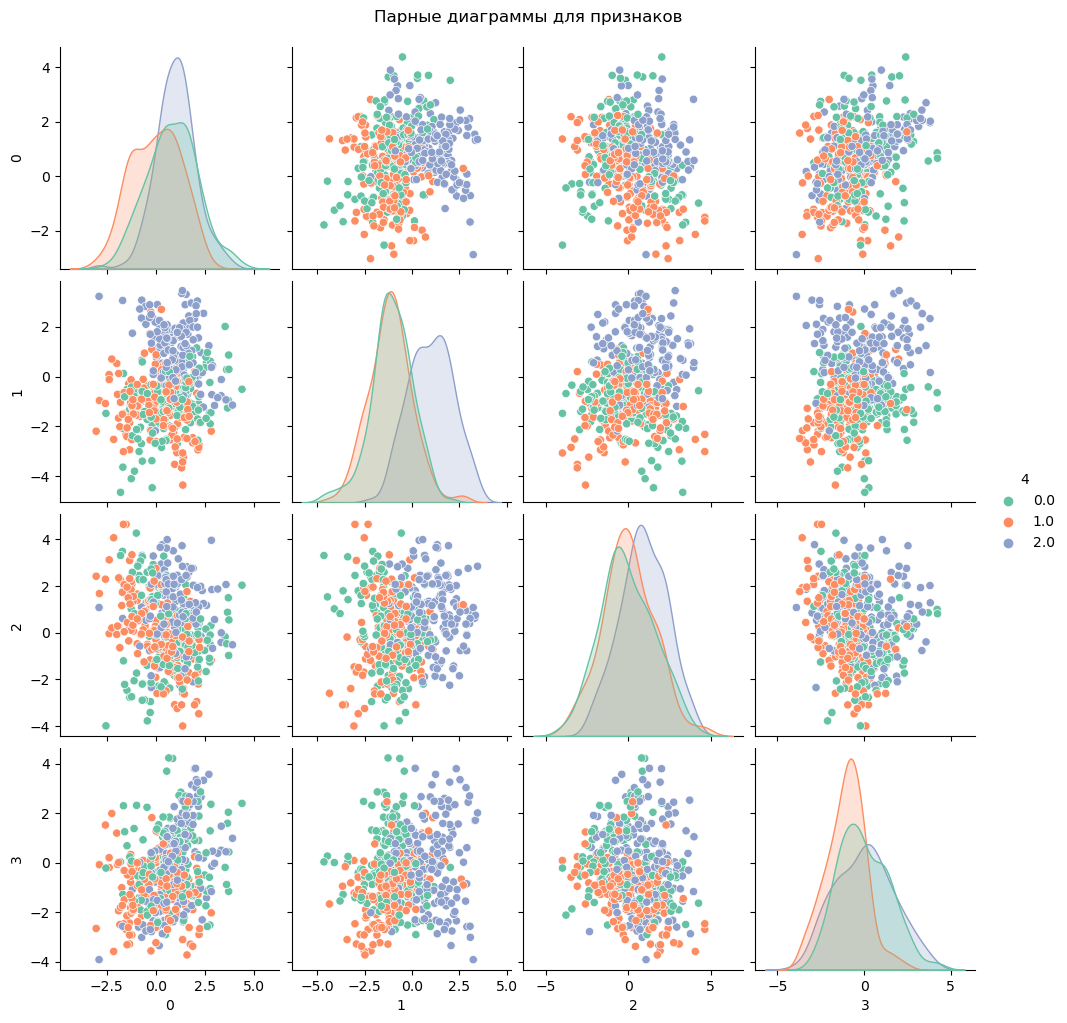

In [325]:
df_ex = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]))
sns.pairplot(df_ex, hue=4, diag_kind='kde', palette='Set2')
plt.suptitle('Парные диаграммы для признаков', y=1.02)
plt.show()

черновик ГРАДИЕНТ

In [194]:
X, y = X_train, y_train

accur_list = []
loc_coefs = []
learning_rates_list = []
learning_rates = [0.01, 0.05, 0.09, 0.12, 0.2]


num, features = X.shape
uniq_value = len(np.unique(y))
Y = np.zeros((num, uniq_value))
Y[np.arange(num), y] = 1
coefs_ = np.zeros((features, uniq_value))
#coefs_ = np.random.randint(1, 5, (features, uniq_value))

In [195]:
def softmax(z):
    exp_z = np.exp(z)
    return exp_z/np.sum(exp_z, axis=1).reshape(-1, 1)

In [199]:
for _ in range(5):
    matrix = np.random.uniform(low=-0.5, high=0.5, size=coefs_.shape)
    coefs_ = coefs_ + matrix
    
    for learning_rate in tqdm(learning_rates):
        for _ in range(100):
            z = X @ coefs_
            prob = softmax(z)
            #считаб разницу в предсказании и суммирую ошибки по всем объектам, взвешивая их значением признаков
            #если отклонение большое градиент будет большим,таким обращом вес будет обновляться сильнее
            #если же отклонение небольшое то градиент соответсввенно будет маленьким
            grad = X.T @ (prob - Y) / num

            #обновляю коэффициенты в направлении град
            coefs_ -= learning_rate * grad
        accur_list.append(accuracy_score(y, np.argmax(softmax(np.dot(X, coefs_)), axis=1)))
        loc_coefs.append(coefs_)
        learning_rates_list.append(learning_rate)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 141.22it/s]


черновик Ньютон

In [ ]:
#Отличие от градиента который использует только первую производную заключается в том что помимо градиента метод Ньютона
#использует гессиана (матрицу вторых производных) чтобы учесть кривизну функции 

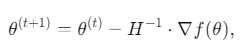

Градиентный спуск использует только первую производную(показ направление изменения) и делает шаг пропорциональный градиенту что может быть неэффективным для функций с резкими изменениями кривизны. То есть гс движется вниз вдоль направления градиента делая равномерные шаги

В свою очередь метод Ньютона учитывает информацию (помимо градиента) о кривизне через гессиан(использцет квадратичное приближение(параболу)к функции вокруг точки и ищет минимум этой параболы, то есть описывает как быстро изменяется направление), что позволяет выбрать оптимальный шаг для перемещения к минимуму.  И в случае если кривая пологая ( широкий минимум) метод корректирует шаг таким образом чтобы шаг был большим. Если кривая резкая ( узкий мин) шаг становится меньшим

In [ ]:
N, m = X.shape
M = len(np.unique(y))   #количество классов

#one-hor encode y
Y = np.zeros((N, M))
Y[np.arange(N), y] = 1

#создаю матрицу коэф ( признаков) для каждого класса (по столбцам разные классы по строкам разные признгаки)
self.coefs_ = np.zeros((m, M))

for _ in range(self.max_iter):
    # линейная комбинация признаков для каждого обьекта по каждому классу
    z = np.dot(X, self.coefs_)
    #вычисляю вероятность для каждого наблюдения каждого класса
    probabilities = self.softmax(z)

    elif self.method == 'newton':
        # Compute gradient
        gradient = np.dot(X.T, (probabilities - Y)) / N

        # Compute Hessian
        R = probabilities * (1 - probabilities)  # Element-wise probabilities
        H = np.zeros((m * M, m * M))  # Hessian matrix (block structure)

        for i in range(N):
            xi = X[i, :].reshape(-1, 1)  # m x 1
            Ri = np.diag(R[i, :])  # M x M diagonal matrix
            H += np.kron(Ri, np.dot(xi, xi.T))

        H /= N

        # Flatten gradient for compatibility with Hessian
        grad_flat = gradient.flatten()

        # Update weights using Newton's method
        delta = np.linalg.solve(H + 1e-4 * np.eye(H.shape[0]), grad_flat) 
        self.coefs_ -= delta.reshape(self.coefs_.shape)

In [340]:
class MulticlassLogisticRegression_last:
    def __init__(self, learning_rate=0.01, max_iter=100, method='gradient', random_state=None):

        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.method = method
        #для обеспеч повторимости результатов при каждом запуске
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)  # генератор случайных чисел
        self.coefs_ = None


    def softmax(self, z):
        """
        Вероятность того что обьект принимает k-ый класс
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # числовая стабилизация
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):

        num, features = X.shape
        uniq_value = len(np.unique(y)) #кол классов
        Y = np.zeros((num, uniq_value))
        #one-hot кодирование классов
        Y[np.arange(num), y] = 1
        #создаю матрицу коэф ( признаков) для каждого класса (по столбцам разные классы по строкам разные признгаки)
        self.coefs_ = np.zeros((features, uniq_value))
        #coefs_ = np.random.randint(1, 5, (features, uniq_value))
        
        if self.method == 'gradient':
            
            accur_list = []
            all_coefs = []
        
            for _ in range(5):
                matrix_loc = self.rng.uniform(low=-0.5, high=0.5, size=self.coefs_.shape)
                self.coefs_ = self.coefs_ + matrix_loc
                for _ in range(self.max_iter):
                    # линейная комбинация признаков для каждого обьекта по каждому классу
                    z = X @ self.coefs_
                    #вычисляю вероятность для каждого наблюдения каждого класса
                    prob = self.softmax(z)
                    #считаб разницу в предсказании и суммирую ошибки по всем объектам, взвешивая их значением признаков
                    #если отклонение большое градиент будет большим,таким обращом вес будет обновляться сильнее
                    #если же отклонение небольшое то градиент соответсввенно будет маленьким
                    grad = X.T @ (prob - Y) / num

                    #обновляю коэффициенты в направлении град
                    self.coefs_ -= self.learning_rate * grad
                
                accur_list.append(accuracy_score(y, np.argmax(self.softmax(np.dot(X, self.coefs_)), axis=1)))
                all_coefs.append(self.coefs_)
            
            self.coefs_ = all_coefs[accur_list.index(max(accur_list))]
            
        elif self.method == 'newton':
                
            for _ in range(self.max_iter):
                # линейная комбинация признаков для каждого обьекта по каждому классу
                z = X @ self.coefs_
                #вычисляю вероятность для каждого наблюдения каждого класса
                prob = self.softmax(z)

                # Compute gradient
                grad = X.T @ (prob - Y) / num

                # Compute Hessian
                R = prob * (1 - prob)  

                H = np.zeros((features * uniq_value, features * uniq_value))  

                for i in range(num):
                    xi = X[i, :].reshape(-1, 1) 
                    Ri = np.diag(prob[i, :]) - np.outer(prob[i, :], prob[i, :])  # более точное вычисление гессиана
                    H += np.kron(Ri, np.dot(xi, xi.T))

                H /= num

                grad_flat = grad.flatten()

                try:
                    delta = np.linalg.solve(H + 1e-4 * np.eye(H.shape[0]), grad_flat) 
                    self.coefs_ -= delta.reshape(self.coefs_.shape)
                except np.linalg.LinAlgError:
                    print("Гессиан вырожден, пропускаем итерацию")

    def predict_proba(self, X):
        """
        функция для предсказания вероятнсоти классов по поданным данным

        """
        z = np.dot(X, self.coefs_)
        return self.softmax(z)

    def predict(self, X):
        """
        функция для предсказания меток класса

        """
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    
    
def plot_decision_boundaries_general(X, y, model):
    if X.shape[1] != 2:
        raise ValueError("Визуализация работает только для 2D размерности")

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.title("Границы принятия решений")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")
    plt.legend(*scatter.legend_elements(), title="Классы")
    plt.show()

In [341]:
#ГРАДИЕНТ

In [353]:
#X, y = make_classification(n_samples=500, n_features=4, n_classes=3, n_informative=3, n_redundant=1, random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)


In [354]:
for i in ['gradient', 'newton']:
    model_my = MulticlassLogisticRegression_last(learning_rate=0.1, max_iter=500, method=i, random_state=22)
    model_my.fit(X_train, y_train)

    y_pred_my = model_my.predict(X_test)

    print(f1_score(y_test, y_pred_my, average='weighted'))

0.6908722612649855
0.7297142857142856


In [356]:
model = LogisticRegression(multi_class='multinomial', max_iter=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f1_score(y_test, y_pred_my, average='weighted'))

0.7297142857142856


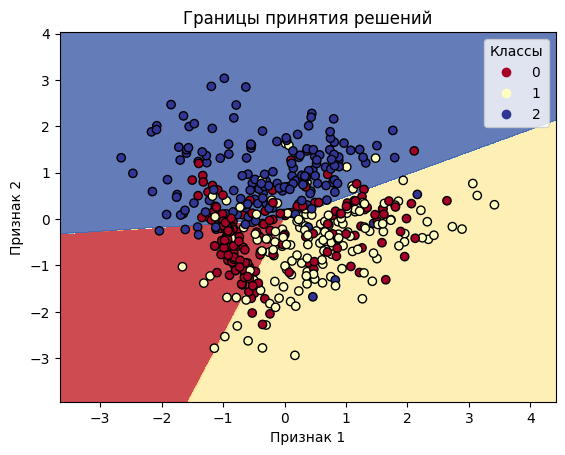

In [254]:
#если признаков больше 2 то снижаю размерность до 2 методом pca 
if X.shape[1] > 2:
    pca = PCA(n_components=2)
    X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = MulticlassLogisticRegression_last(learning_rate=0.1, max_iter=100, method='gradient', random_state=22)
model.fit(X_train, y_train)

plot_decision_boundaries_general(np.vstack((X_train, X_test)), np.hstack((y_train, y_test)), model)



In [280]:

model = MulticlassLogisticRegression(learning_rate=0.1, max_iter=5, method='newton')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.55


In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [153]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=100, method='gradient'):

        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.method = method
        self.coefs_ = None

    def softmax(self, z):
        """
        Вероятность того что обьект принимает k-ый класс
        """
        #вычту максимум по данной строки всех элементов чтобы не быоо слишком большое число
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):

        N, m = X.shape
        M = len(np.unique(y))   #количество классов

        #one-hor encode y
        Y = np.zeros((N, M))
        Y[np.arange(N), y] = 1

        #создаю матрицу коэф ( признаков) для каждого класса (по столбцам разные классы по строкам разные признгаки)
        self.coefs_ = np.zeros((m, M))

        for _ in range(self.max_iter):
            # линейная комбинация признаков для каждого обьекта по каждому классу
            z = np.dot(X, self.coefs_)
            #вычисляю вероятность для каждого наблюдения каждого класса
            probabilities = self.softmax(z)

            if self.method == 'gradient':
                # считаю градиент и усредняю
                gradient = np.dot(X.T, (probabilities - Y)) / N
                
                self.coefs_ -= self.learning_rate * gradient

            elif self.method == 'newton':
                # Compute gradient
                gradient = np.dot(X.T, (probabilities - Y)) / N

                # Compute Hessian
                R = probabilities * (1 - probabilities)  # Element-wise probabilities
                H = np.zeros((m * M, m * M))  # Hessian matrix (block structure)

                for i in range(N):
                    xi = X[i, :].reshape(-1, 1)  # m x 1
                    Ri = np.diag(R[i, :])  # M x M diagonal matrix
                    H += np.kron(Ri, np.dot(xi, xi.T))

                H /= N

                # Flatten gradient for compatibility with Hessian
                grad_flat = gradient.flatten()

                # Update weights using Newton's method
                delta = np.linalg.solve(H + 1e-4 * np.eye(H.shape[0]), grad_flat) 
                self.coefs_ -= delta.reshape(self.coefs_.shape)

    def predict_proba(self, X):
        """
        функция для предсказания вероятнсоти классов по поданным данным

        """
        z = np.dot(X, self.coefs_)
        return self.softmax(z)

    def predict(self, X):
        """
        функция для предсказания меток класса

        """
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)
